In [1]:
#使用时间序列模型预测货物价格
import numpy as np
import pandas as pd 
import random as rd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns



from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller,acf,pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs



#settings
import warnings
warnings.filterwarnings('ignore')

In [2]:
sales = pd.read_csv('sales_train.csv')
item_cat = pd.read_csv('item_categories.csv')
item = pd.read_csv('items.csv')
sub = pd.read_csv('sample_submission.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')


In [3]:
#对时间进行标准化处理
print(sales.head(4))

sales['date'] = sales['date'].apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))
print(sales.info())
print(sales.date[3].month)

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None
1


In [4]:
monthly_sales = sales.groupby(['date_block_num','shop_id','item_id'])['date','item_price','item_cnt_day'].agg(
{'date':['min','max'],'item_price':'mean','item_cnt_day':'sum'})


In [5]:





# df_shop_name = pd.merge(monthly_sales,shops, on = 'shop_id',how='outer')
# # df_shop_name.columns
# # df_shop_monthly_order

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [6]:


# x = item.groupby(['item_categories_id']).count()
# x = x.sort_values(by='item_id',ascending =False)
# x= x.ioc[0:10].reset_index()

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [8]:


'''
The objective requires us to predict sales for the next month at a store-item combination

'''

'\nThe objective requires us to predict sales for the next month at a store-item combination\n\n'

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1.0
1,2013-01-03,0,25,2552,899.0,1.0
2,2013-01-05,0,25,2552,899.0,-1.0


In [10]:
sales['year'] = sales['date'].apply(lambda x: x.year)
sales['month'] =sales['date'].apply(lambda x: x.month)

In [11]:
sales.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
0,2013-01-02,0,59,22154,999.0,1.0,2013,1
1,2013-01-03,0,25,2552,899.0,1.0,2013,1
2,2013-01-05,0,25,2552,899.0,-1.0,2013,1


In [12]:
# sales_item_cnt_month = sales.groupby(['year','month','item_id'])['item_cnt_day'].count()


In [13]:
# sales_item_cnt_month.head(3)

In [14]:
#分析

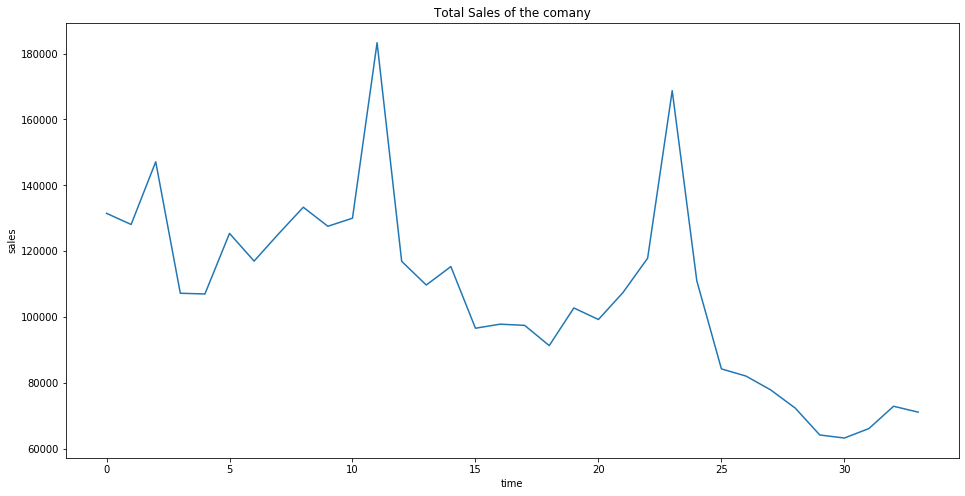

In [15]:
ts = sales.groupby('date_block_num')['item_cnt_day'].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the comany')
plt.xlabel('time')
plt.ylabel('sales')
plt.plot(ts)
fig = plt.gcf()
fig.savefig('./fig1')

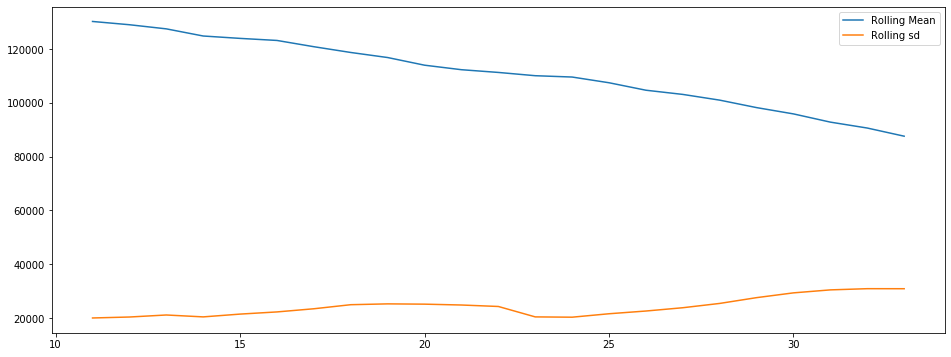

In [16]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(12).mean(),label ='Rolling Mean')
plt.plot(ts.rolling(12).std(),label = 'Rolling sd')
plt.legend()

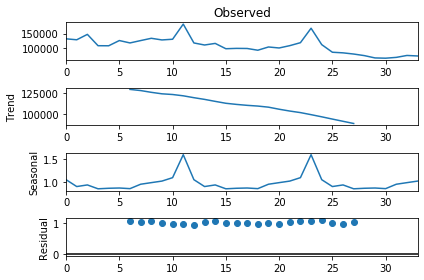

In [17]:
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(ts.values,freq =12,model='multiplicative')#乘法模型 ts是series
fig = res.plot()

In [18]:
ts.values

array([131479., 128090., 147142., 107190., 106970., 125381., 116966.,
       125291., 133332., 127541., 130009., 183342., 116899., 109687.,
       115297.,  96556.,  97790.,  97429.,  91280., 102721.,  99208.,
       107422., 117845., 168755., 110971.,  84198.,  82014.,  77827.,
        72295.,  64114.,  63187.,  66079.,  72843.,  71056.])

In [19]:
type(ts)

pandas.core.series.Series

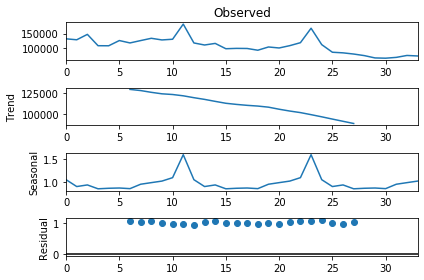

In [20]:
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(ts.values,freq =12,model='multiplicative')#加法模型 ts是series fre只是保证residual两端不为0
fig = res.plot() 

In [21]:

def test_stationarity(timeseries):
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[:4], index= ['Test Statisitic', 'p-value', '#lagsUsed','number of Obserbations used'])
    for key,values in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = values
    print(dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statisitic                -2.395704
p-value                         0.142953
#lagsUsed                       0.000000
number of Obserbations used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [22]:
#remove trend
from pandas import Series as Series

def difference(dataset, interval =1):
    diff = list()
    for i in range(interval,len(dataset)):
        value = dataset[i] - dataset[i-interval]
        diff.append(value)
    return Series(diff)
    
def inverse_difference(last_ob,value):
    return value + last_ob

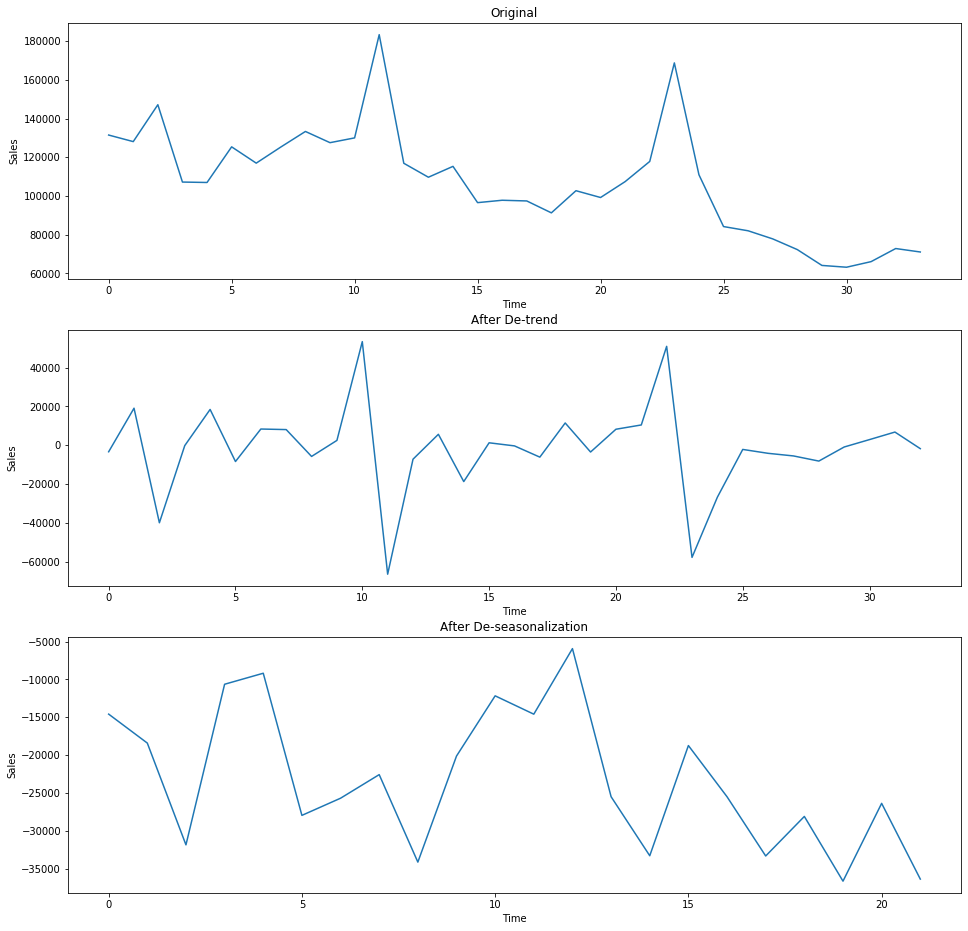

In [23]:
ts = sales.groupby('date_block_num')['item_cnt_day'].sum()
ts.astype('float')
plt.figure(figsize = (16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts1= difference(ts)
plt.plot(new_ts1)

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts2 = difference(ts,12)
plt.plot(new_ts2)

In [24]:
print('new_ts1:')
test_stationarity(new_ts1)
print('new_ts2:')
test_stationarity(new_ts2)

new_ts1:
Results of Dickey-Fuller Test:
Test Statisitic               -1.363622e+01
p-value                        1.686395e-25
#lagsUsed                      1.000000e+01
number of Obserbations used    2.200000e+01
Critical Value (1%)           -3.769733e+00
Critical Value (5%)           -3.005426e+00
Critical Value (10%)          -2.642501e+00
dtype: float64
new_ts2:
Results of Dickey-Fuller Test:
Test Statisitic                -3.270101
p-value                         0.016269
#lagsUsed                       0.000000
number of Obserbations used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [25]:
#建立模型 根据acf和pacf判断 acf衰减趋于0或者震荡，p阶pacf截尾，说明前n个月和第n月有关联，用Ar模型。q阶acf截尾，
#pacf衰减趋于0且震荡，用MA模型，arima即 Ar(p) Ma(q) MA关注的是误差项的累积
  

In [26]:
#画图 lag 就是取多少个时间窗口
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)#画出acf图像
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)#画出pacf图像
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [27]:
# np.random.seed(1)
# n_smaples = 1000
# a =0.6
# x= w = np.random.normal(size = n_smaples)

# for t in range(n_smaples):
#     x[t] = a*x[t-1] +w[t]
    
# limit =12
# tsplot(x, lags=limit, title = "AR(1)process")
#举例观察pacf和acf

In [28]:
#寻找best aic
best_aic = np.inf#无穷大
best_order = None
best_mdl = None

rng = range(5)
#用try except是因为模型可能会报错

for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts2.values, order=(i, j)).fit(method='mle', trend='nc')
            
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
                print(best_aic)
        except:
                print('error')

                
                print(best_aic,best_order)
            
            
# print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
#AIc越小模型越好

error
inf None
492.856060764807
491.43551044237313
486.78803655472245
481.4161478269308
476.80866461583594
472.9970259779833
error
472.9970259779833 (1, 1)
error
472.9970259779833 (1, 1)
error
472.9970259779833 (1, 1)
error
472.9970259779833 (1, 1)
error
472.9970259779833 (1, 1)
error
472.9970259779833 (1, 1)
error
472.9970259779833 (1, 1)
error
472.9970259779833 (1, 1)
error
472.9970259779833 (1, 1)
error
472.9970259779833 (1, 1)
error
472.9970259779833 (1, 1)
error
472.9970259779833 (1, 1)
error
472.9970259779833 (1, 1)
error
472.9970259779833 (1, 1)


In [29]:
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [30]:
from fbprophet import Prophet

total_sales = sales.groupby('date_block_num')['item_cnt_day'].sum()
dates = pd.date_range(start = '2013-01-01', end = '2015-10-01',freq='MS')
total_sales.index =dates
total_sales.head(3)


2013-01-01    131479.0
2013-02-01    128090.0
2013-03-01    147142.0
Freq: MS, Name: item_cnt_day, dtype: float64

In [40]:
monthly_sales = sales.groupby(['shop_id','item_id','date_block_num'])['item_cnt_day'].sum()
#由series生成dataframe
monthly_sales = monthly_sales.unstack(level =-1).fillna(0)
monthly_sales = monthly_sales.T
dates = pd.date_range(start='2013-01-01',end='2015-10-01',freq='MS')
monthly_sales.index =dates
monthly_sales = monthly_sales.reset_index()
monthly_sales.head(3)


shop_id      index     0                                             ...  \
item_id               30    31    32   33    35   36   40   42   43  ...   
0       2013-01-01   0.0   0.0   6.0  3.0   1.0  0.0  0.0  0.0  1.0  ...   
1       2013-02-01  31.0  11.0  10.0  3.0  14.0  1.0  1.0  1.0  0.0  ...   
2       2013-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   

shop_id    59                                                        
item_id 22144 22145 22150 22151 22153 22154 22155 22162 22164 22167  
0         0.0   0.0   0.0   2.0   0.0   1.0   0.0   0.0   0.0   0.0  
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  

[3 rows x 424125 columns]

In [43]:
import time 


In [44]:
monthly_shop_sales=sales.groupby(["date_block_num","shop_id"])["item_cnt_day"].sum()
# get the shops to the columns
monthly_shop_sales=monthly_shop_sales.unstack(level=1)
monthly_shop_sales=monthly_shop_sales.fillna(0)
monthly_shop_sales.index=dates
monthly_shop_sales=monthly_shop_sales.reset_index()
monthly_shop_sales.head()

shop_id,index,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
0,2013-01-01,5578.0,2947.0,1146.0,767.0,2114.0,0.0,3686.0,2495.0,1463.0,...,3406.0,2748.0,1812.0,2055.0,9386.0,0.0,3238.0,0.0,0.0,2017.0
1,2013-02-01,6127.0,3364.0,488.0,798.0,2025.0,877.0,4007.0,2513.0,1156.0,...,3054.0,2284.0,1737.0,1906.0,8075.0,0.0,2655.0,0.0,0.0,1897.0
2,2013-03-01,0.0,0.0,753.0,959.0,2060.0,1355.0,4519.0,2460.0,977.0,...,3610.0,2605.0,2034.0,2365.0,9488.0,0.0,3099.0,6586.0,3773.0,2028.0
3,2013-04-01,0.0,0.0,583.0,647.0,285.0,1008.0,3168.0,1540.0,-1.0,...,2740.0,1945.0,1446.0,1515.0,6726.0,0.0,2153.0,5493.0,2831.0,1388.0
4,2013-05-01,0.0,0.0,553.0,710.0,1211.0,1110.0,3022.0,1647.0,0.0,...,2839.0,2243.0,1482.0,1767.0,7006.0,852.0,2140.0,5233.0,2308.0,1374.0


In [45]:
start_time=time.time()

# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_shop_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_shop_sales.iloc[:,0], monthly_shop_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [46]:
forecastsDict

{0:            ds        trend   yhat_lower   yhat_upper  trend_lower  \
 0  2013-01-01  -669.832052  2894.041818  4878.961310  -669.832052   
 1  2013-02-01  -701.867110  3120.277148  5209.359094  -701.867110   
 2  2013-03-01  -730.802001 -1722.267399   227.034182  -730.802001   
 3  2013-04-01  -762.837059 -1348.445646   668.581328  -762.837059   
 4  2013-05-01  -793.838728  -851.676075  1147.900999  -793.838728   
 5  2013-06-01  -825.873786  -492.037804  1507.834547  -825.873786   
 6  2013-07-01  -856.875455  -209.107390  1770.305336  -856.875455   
 7  2013-08-01  -888.910513  -246.845245  1854.185134  -888.910513   
 8  2013-09-01  -920.945570  -255.533249  1662.147069  -920.945570   
 9  2013-10-01  -951.947237  -660.330450  1310.703252  -951.947237   
 10 2013-11-01  -983.982293 -1066.299020   905.491400  -983.982293   
 11 2013-12-01 -1014.983961 -1730.125446   229.702311 -1014.983961   
 12 2014-01-01 -1047.019015   811.344103  2851.174590 -1047.019015   
 13 2014-02-01 -1